## Setting up our Python environment

In addition to the normal inputs, we'll grab Bessel functions from `scipy.special`. There are different conventions, but we'll mostly be using the $J_n$'s

In [1]:
import numpy as np, scipy as sp, matplotlib.pyplot as plt, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
from matplotlib import cm
from numpy import sin, cos, arctan, arctan2, array, sqrt, linspace, meshgrid, pi
%matplotlib inline
import scipy.special
from scipy.special import j0,j1,jn,y0,y1,yn, jn_zeros


# Let's re-familiarize ourselves with Bessel functions

### J's

Make a little widget to plot as many Bessel functions of the first kind as we want:

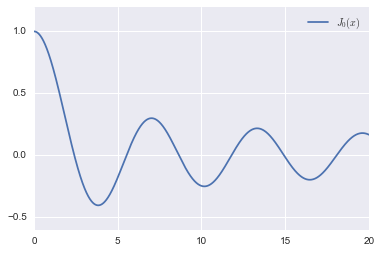

In [2]:
x = np.linspace(0,20,10000)
def plotfirstkind(N=0):
    for n in range(N):
        plt.plot(x,jn(n,x),label="$J_{n}(x)$".format(n=n))
    if N>0: plt.legend()
interact(plotfirstkind,N=(0,10))

### Y's

Make a little widget to plot as many Bessel functions of the second kind as we want

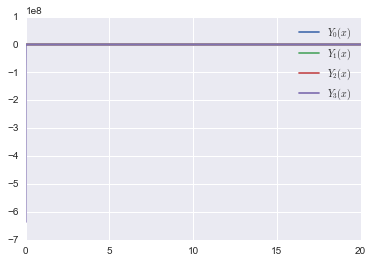

In [3]:
x = np.linspace(0,20,10000)
def plotsecondkind(N=0):
    for n in range(N):
        plt.plot(x,yn(n,x),label="$Y_{n}(x)$".format(n=n))
    if N>0: plt.legend()
interact(plotsecondkind,N=(0,10))

Oops! How many bessel functions of the second kind to plot?

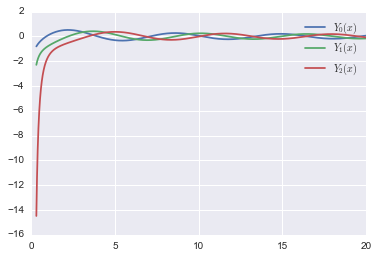

In [4]:
def plotsecondkind(N=0,x0=0):
    x = np.linspace(x0,20,10000)
    for n in range(N):
        plt.plot(x,yn(n,x),label="$Y_{n}(x)$".format(n=n))
    if N>0: plt.legend()
interact(plotsecondkind,N=(0,10),x0=(0,1,0.1))

Or maybe this

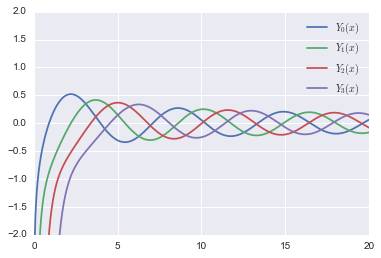

In [5]:
def plotsecondkind(N=0,ymax=2,ymin=-2):
    x = np.linspace(0,20,10000)
    for n in range(N):
        plt.plot(x,yn(n,x),label="$Y_{n}(x)$".format(n=n))
    plt.ylim([ymin,ymax])
    if N>0: plt.legend()
interact(plotsecondkind,N=(0,10),x0=(0,1,0.1))

### Great. Now a series.

This one happens to be designed to make a square wave up to the first zero.

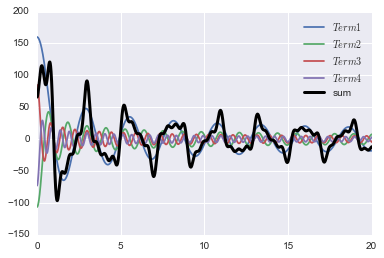

In [6]:
x = np.linspace(0,20,10000)

def k(m,n):
    # jn_zeros(n, nt): Compute nt zeros of the Bessel function Jn(x).
    return jn_zeros(n,m)[m-1] # m is 0-indexed here

def km0(m):
    #jn_zeros(n, nt): Compute nt zeros of the Bessel function Jn(x).
    # I.e. this returns an array, and we take the last element.
    return jn_zeros(0,m)[-1]

def plotseries(N=0):
    plt.clf()
    y = np.zeros_like(x)
    for m in range(1,N+1):
        km = km0(m)
        cm = 200/(km * jn(1,km))
        #print "cm",cm
        this_term = cm*jn(0,km*x)
        plt.plot(x,this_term,label="$Term %s$"%m)
        y = y + this_term
    plt.plot(x,y,'k',linewidth=3,label='sum')
    plt.legend()
interact(plotseries,N=(1,10))

# Now on to drum heads

Assuming you solved this in class, you know we're looking for things like

$J_n(k_{m,n})R\cos(n\theta)\cos(k_{m,n}vt)$

So, let's plot that. Remember, we want the above function over the drum head, and zero elsewhere.

First, let's all read through Boas together

... reading ...

Now let's plot some things!

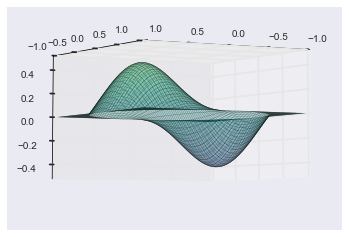

In [7]:
v = 1

def generate(X, Y, t, n, m, v, f1, f2):
    theta = arctan2(Y,X) # This does arctan(Y/X) but gets the sign right.
    R = sqrt(X**2 + Y**2)
    # We know z = J_n(k*r)*cos(n*theta)*cos(k*v*t)
    # 
    f1 = {'sin':sin,'cos':cos}[f1]
    f2 = {'sin':sin,'cos':cos}[f2]

    result = jn(n,k(m,n)*R)*f1(n*theta)*f2(k(m,n)*v*t)
    result[R>1] = 0  # we plot points from the square, but physically require this.
    return result

Npoints = 200
xs = linspace(-1, 1, Npoints)
ys = linspace(-1, 1, Npoints)
X, Y = meshgrid(xs, ys)

periods = 2
frames_per = 50
def plotframe(t=0,n=0,m=1,elev=20,azim=60,f1='cos',f2='cos'):
    # one period is 2*pi/jn_zeros(n,m)[m-1]
    t = t*2*pi/jn_zeros(n,m)[m-1]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Z = generate(X, Y, t, n, m,v,f1,f2)
    ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.3, cmap=cm.viridis, vmin=-1, vmax=1)

    if n == 0:
        ax.set_zlim(-1,1)
    else:
        ax.set_zlim(-0.5,0.5)
    ax.view_init(elev=elev, azim=azim)
    plt.draw()

interact(plotframe,t=(0,periods,periods/frames_per),n=(0,10),m=(1,10),elev=(-180,180,1),azim=(-180,180,1),
        f1=['sin','cos'],f2=['sin','cos'])

And now let's plot a grid, complete with nodelines!

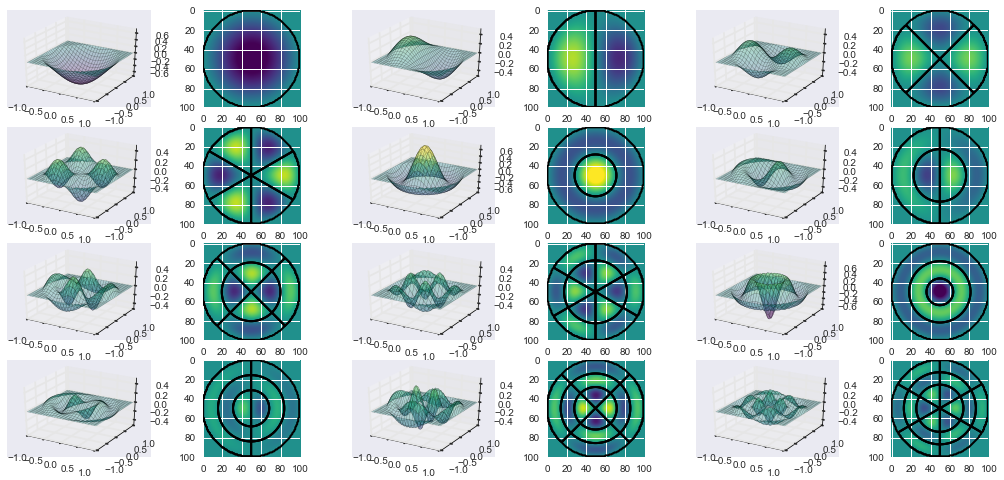

In [8]:
v = 1

Npoints = 100
xs = linspace(-1, 1, Npoints)
ys = linspace(-1, 1, Npoints)
X, Y = meshgrid(xs, ys)

periods = 2
frames_per = 50
def plotframe2(t=0,nmax=1,mmax=2):
    # one period is 2*pi/jn_zeros(n,m)[m-1]
    #t = t*2*pi/jn_zeros(n,m)[m-1]
    ns = list(range(0,nmax))
    ms = list(range(1,mmax))
    fig = plt.figure(figsize=(6*len(ms),2*(len(ns))))
    
    axs = {}
    rows, cols = len(ns), 2*len(ms)

    idx = 1
    for m in ms:
        axs[m] = {}
        for n in ns:
            axs[m][n] = (fig.add_subplot(rows,cols,idx, projection='3d'),
                        fig.add_subplot(rows,cols,idx+1))
            idx += 2

    
    for m in ms:
        for n in ns:
            Z = generate(X, Y, t, n, m, v, 'cos', 'cos')
            axs[m][n][0].plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.3, cmap=cm.viridis, vmin=-0.7,vmax=0.7,)

            if n == 0:
                axs[m][n][0].set_zlim(-0.7,.7)
                axs[m][n][1].imshow(Z,vmin=-0.7,vmax=0.7, cmap=cm.viridis)
            else:
                axs[m][n][0].set_zlim(-0.5,0.5)
                axs[m][n][1].imshow(Z,vmin=-0.5,vmax=0.5, cmap=cm.viridis)
            # The funny business with levels here is because you won't
            # get a contour exactly at zero that necessarily tracks
            # around both sides of the circle due to the fact that
            # we've discretized things.
            levels = [-0.000000001,0.0,0.000000001]
            axs[m][n][1].contour(Z, levels, colors='k',
                                 linestyles='solid', linewidths=2)
    
interact(plotframe2,t=(0,periods,periods/frames_per),nmax=(1,5),mmax=(2,5))